In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np

import astropy.units as u
import astropy.constants as c

import warnings

from read import read_pbh, output_specs

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file(f"{WDIR}/matplotlibrc")

In [4]:
from scipy import interpolate
from dm21cm.utils import load_h5_dict

In [7]:
from read import read_pbh

In [9]:
results_dir = '/n/home07/yitians/dm21cm/blackhawk/BlackHawk_v2.2/results'
run_name = 'm13.200_sec'

run_dir = f"{results_dir}/{run_name}"

evol_data = read_pbh(run_dir, 'evolution')

In [11]:
evol_data['t'].shape

(689,)

In [14]:
m_PBH = 10**13.2 # [g]
data_dir = f'{WDIR}/data/pbh'
data = load_h5_dict(f'{data_dir}/pbh_logm{np.log10(m_PBH):.3f}.h5')
t_arr = data['t'] # [s]

print(t_arr.shape)
print(data['M'].shape)

M_t = interpolate.interp1d(t_arr, data['M'], bounds_error=False, fill_value=0) # [g]([s])
i_start = np.where(t_arr > 1e10)[0][0] # [s]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    dMdt = np.abs(np.gradient(data['M'][i_start:], t_arr[i_start:])) # [g/s]
dMdt_t = interpolate.interp1d(t_arr[i_start:], dMdt, bounds_error=False, fill_value=0) # [g/s]([s])

(689,)
(689,)


In [15]:
from astropy.cosmology import Planck18 as cosmo

In [16]:
t = cosmo.age(6-1).to(u.s).value # [s]
print(t)
dMdt_t(t)

3.694467295937175e+16


array(0.)

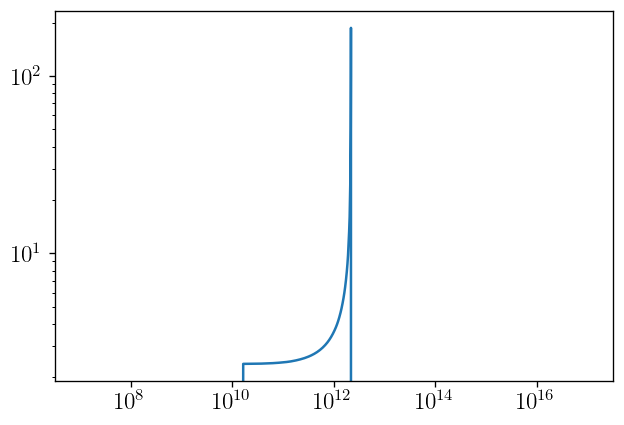

In [20]:
t = np.geomspace(1e7, 1e17, 100)
plt.plot(t, dMdt_t(t), label='M')
plt.xscale('log')
plt.yscale('log')

In [25]:
t = np.geomspace(1e7, 1e17, 100)
a = dMdt_t(t)
a

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 2.37990842, 2.38131054, 2.38307981,
       2.38573752, 2.39080771, 2.39720557, 2.4056848 , 2.41784899,
       2.43319846, 2.45404718, 2.48515404, 2.525291  , 2.5779035 ,
       2.64876525, 2.74536268, 2.88234178, 3.07950195, 3.38424169,
       3.88502996, 4.87840624, 7.66393672, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [29]:
sys.path.append(os.environ['DH_DIR'])
import darkhistory.physics as phys

In [30]:
rs_s = []
dt_s = []
dM_s = []
rs = 3000
coarsen_factor = 10
dlnz = 0.001
while rs > 4: # darkhistory loop
    dt = dlnz * coarsen_factor / phys.hubble(rs)
    t = cosmo.age(rs-1).to(u.s).value # [s]
    dM = dMdt_t(t) * dt
    rs_s.append(rs)
    dt_s.append(dt)
    dM_s.append(dM)
    rs = np.exp(np.log(rs) - dlnz * coarsen_factor) # next_rs

i_final_inj = np.nonzero(dM_s)[0][-1]
rs_final_inj = rs_s[i_final_inj]
print(rs_final_inj)

2882.3683174569696


In [34]:
i_final_inj

4

In [39]:
dM_s[i_final_inj+1]

0.0

In [33]:
i = np.nonzero(a)[0][-1]
a[i]

7.66393672207485

In [27]:
zero_spec = data['phot dNdEdt'][0] * 0.
phot_dNdEdt_interp = interpolate.interp1d(t_arr, data['phot dNdEdt'], axis=0, bounds_error=False, fill_value=zero_spec) # [phot / eV s BH]
elec_dNdEdt_interp = interpolate.interp1d(t_arr, data['elec dNdEdt'], axis=0, bounds_error=False, fill_value=zero_spec) # [elec / eV s BH]

In [46]:
from darkhistory.config import load_data
from darkhistory.spec.spectrum import Spectrum
binning = load_data('binning')
binning.keys()

dict_keys(['elec', 'elecE', 'eleceng', 'ics_eng', 'ics_eng_1k', 'ics_rel_eng', 'ics_rel_eng_1k', 'phot', 'photE', 'photeng', 'rs0', 'rs1', 'rs2', 'xH0', 'xH1', 'xHe0'])

In [49]:
rs = rs_s[i_final_inj+1]
t = cosmo.age(rs-1).to(u.s).value # [s]
dNdEdt = phot_dNdEdt_interp(t)
s = Spectrum(binning['photE'], dNdEdt, spec_type = 'dNdE')
s.toteng()

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


0.0

# PBHInjection

In [3]:
from dm21cm.injections.pbh import PBHInjection
from dm21cm.utils import load_h5_dict

In [6]:
data_dir = os.environ['DM21CM_DATA_DIR']
abscs = load_h5_dict(f"{data_dir}/abscissas.h5")
inj = PBHInjection(m_PBH=10**13.2)
inj.set_binning(abscs)
inj.init_final_inj(start_rs=3000, end_rs=5, coarsen_factor=10, dlnz=0.001)

In [7]:
inj.inj_multiplier_final

1.6693999842197502

In [8]:
inj.rs_final_inj

2882.3683174569696

In [15]:
plt.plot(abscs['photE'], inj.inj_phot_spec(2881).N / inj.inj_phot_spec(2881).toteng())
plt.plot(abscs['photE'], inj.inj_phot_spec_final(2881).N / inj.inj_phot_spec_final(2881).toteng())
plt.loglog()
plt.ylim(1e-30, 1e-15)

AttributeError: 'PBHInjection' object has no attribute 'z_final_inj'

(1e-30, 1e-15)

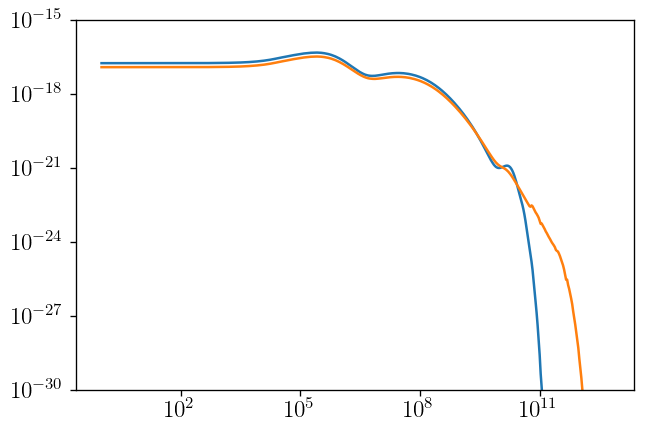

In [13]:
plt.plot(abscs['elecEk'], inj.inj_elec_spec(2881).dNdE / inj.inj_elec_spec(2881).toteng())
plt.plot(abscs['elecEk'], inj.inj_elec_spec_final(2881).dNdE / inj.inj_elec_spec_final(2881).toteng())
plt.loglog()
plt.ylim(1e-30, 1e-15)

In [14]:
abscs['zplusone_step_factor']

1.002